1. Modified `get_batch` to generate data pair like ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox)...


In [1]:
from collections import Counter
import random
import os
import sys
sys.path.append('..')
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
EXPECTED_BYTES = 31344016
DATA_FOLDER = 'data/'
FILE_NAME = 'text8.zip'


def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
    	pass

def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    file_path = DATA_FOLDER + file_name
    if os.path.exists(file_path):
        print("Dataset ready")
        return file_path
    file_name, _ = urllib.request.urlretrieve(DOWNLOAD_URL + file_name, file_path)
    file_stat = os.stat(file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return file_path    
    
    
def read_data(file_path):
    """ Read data into a list of tokens"""
    with zipfile.ZipFile(file_path) as f:
        words = tf.compat.as_str(f.read(f.namelist()[0])).split()
        # tf.compat.as_str() converts the input into the string
    return words

def build_vocab(words, vocab_size):
    """ Build vocabulary of VOCAB_SIZE most frequent words """
    dictionary = dict()
    count = [('UNK', -1)]
    count.extend(Counter(words).most_common(vocab_size - 1))
    index = 0
    make_dir('processed')
    with open('processed/vocab_1000.tsv', "w") as f:
        for word, _ in count:
            dictionary[word] = index
            if index < 1000:
                f.write(word + "\n")
            index += 1
    index_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, index_dictionary

def convert_words_to_index(words, dictionary):
    """ Replace each word in the dataset with its index in the dictionary """
    return [dictionary[word] if word in dictionary else 0 for word in words]

def generate_sample(index_words, context_window_size):
    """ Form training pairs according to the cbow model. """
    for index, target in enumerate(index_words): 
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        a = index_words[max(0, index - 1)]
        b = index_words[min(len(index_words)-1, index + 1)]
        yield a, b, target

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        a_batch = np.zeros(batch_size, dtype=np.int32)
        b_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1])
        for index in range(batch_size):
            a_batch[index], b_batch[index], target_batch[index] = next(iterator)
        yield a_batch, b_batch, target_batch
        
def get_batch_gen(index_words, context_window_size, batch_size):
    """ Return a python generator that generates batches"""
    single_gen = generate_sample(index_words, context_window_size)
    batch_gen = get_batch(single_gen, batch_size)
    return batch_gen
        
def process_data(vocab_size):
    """ Read data, build vocabulary and dictionary"""
    file_path = download(FILE_NAME, EXPECTED_BYTES)
    words = read_data(file_path)
    dictionary, index_dictionary = build_vocab(words, vocab_size)
    index_words = convert_words_to_index(words, dictionary)
    del words # to save memory
    return index_words, dictionary, index_dictionary

ImportError: Traceback (most recent call last):
  File "/home/mosquito/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/mosquito/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/mosquito/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/mosquito/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/mosquito/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.8.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

2. Sum and average
```python
embed_a = tf.nn.embedding_lookup(self.embed_matrix, self._a, name='embed_a')
embed_b = tf.nn.embedding_lookup(self.embed_matrix, self._b, name='embed_b')
embed = tf.divide(tf.add(embed_a, embed_b), tf.constant(2, tf.float32,), name='embed')
```
3. Calculate the loss
```python
self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                          biases=nce_bias,
                                          labels=self.target_words,
                                          inputs=embed,
                                          num_sampled=self.hps.num_sampled,
                                          num_classes=self.hps.vocab_size), name='loss')
```
4. Change Optimizer
```python
self.optimizer = tf.train.GradientDescentOptimizer(self.hps.lr)
```

In [2]:
from __future__ import absolute_import # use absolute import instead of relative import

# '/' for floating point division, '//' for integer division
from __future__ import division  
from __future__ import print_function  # use 'print' as a function

import os
import numpy as np
import tensorflow as tf


# from process_data import make_dir, get_batch_gen, process_data
class SkipGramModel:
  """ Build the graph for word2vec model """
  def __init__(self, hparams=None):

    if hparams is None:
        self.hps = get_default_hparams()
    else:
        self.hps = hparams

    # define a variable to record training progress
    self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    
  def _create_input(self):
    """ Step 1: define input and output """

    with tf.name_scope("data"):
      self.a = tf.placeholder(tf.int32, [self.hps.num_pairs], name='a')
      self.b = tf.placeholder(tf.int32, [self.hps.num_pairs], name='b')
      self.targets = tf.placeholder(tf.int32, [self.hps.num_pairs, 1], name='targets')
      dataset = tf.contrib.data.Dataset.from_tensor_slices((self.a, self.b, self.targets))
      dataset = dataset.repeat() # # Repeat the input indefinitely
      dataset = dataset.batch(self.hps.batch_size)
      
      self.iterator = dataset.make_initializable_iterator()  # create iterator
      self._a, self._b, self.target_words = self.iterator.get_next()

  def _create_embedding(self):
    """ Step 2: define weights. 
        In word2vec, it's actually the weights that we care about
    """
    with tf.device('/gpu:0'):
      with tf.name_scope("embed"):
        self.embed_matrix = tf.Variable(
                              tf.random_uniform([self.hps.vocab_size,
                                                 self.hps.embed_size], -1.0, 1.0),
                                                 name='embed_matrix')

  def _create_loss(self):
    """ Step 3 + 4: define the model + the loss function """
    with tf.device('/cpu:0'):
      with tf.name_scope("loss"):
        # Step 3: define the inference
        embed_a = tf.nn.embedding_lookup(self.embed_matrix, self._a, name='embed_a')
        embed_b = tf.nn.embedding_lookup(self.embed_matrix, self._b, name='embed_b')
        embed = tf.divide(tf.add(embed_a, embed_b), tf.constant(2, tf.float32,), name='embed')
        #embed = tf.nn.embedding_lookup(self.embed_matrix, self._a, name='embed_a')

        # Step 4: define loss function
        # construct variables for NCE loss
        nce_weight = tf.Variable(
                        tf.truncated_normal([self.hps.vocab_size, self.hps.embed_size],
                                            stddev=1.0 / (self.hps.embed_size ** 0.5)),
                                            name='nce_weight')
        nce_bias = tf.Variable(tf.zeros([self.hps.vocab_size]), name='nce_bias')

        # define loss function to be NCE loss function
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                  biases=nce_bias,
                                                  labels=self.target_words,
                                                  inputs=embed,
                                                  num_sampled=self.hps.num_sampled,
                                                  num_classes=self.hps.vocab_size), name='loss')

  def _create_optimizer(self):
    """ Step 5: define optimizer """
    with tf.device('/gpu:0'):
      self.optimizer = tf.train.GradientDescentOptimizer(self.hps.lr).minimize(self.loss,
                                                         global_step=self.global_step)
  
  def _build_nearby_graph(self):
    # Nodes for computing neighbors for a given word according to
    # their cosine distance.
    self.nearby_word = tf.placeholder(dtype=tf.int32)  # word id
    nemb = tf.nn.l2_normalize(self.embed_matrix, 1)
    nearby_emb = tf.gather(nemb, self.nearby_word)
    nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
    self.nearby_val, self.nearby_idx = tf.nn.top_k(nearby_dist,
                                         min(1000, self.hps.vocab_size))
    
  def _build_eval_graph(self):
    """Build the eval graph."""
    # Eval graph

    # Each analogy task is to predict the 4th word (d) given three
    # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
    # predict d=paris.

    # The eval feeds three vectors of word ids for a, b, c, each of
    # which is of size N, where N is the number of analogies we want to
    # evaluate in one batch.
    self.analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
    self.analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
    self.analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

    # Normalized word embeddings of shape [vocab_size, emb_dim].
    nemb = tf.nn.l2_normalize(self.embed_matrix, 1)

    # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
    # They all have the shape [N, emb_dim]
    a_emb = tf.gather(nemb, self.analogy_a)  # a's embs
    b_emb = tf.gather(nemb, self.analogy_b)  # b's embs
    c_emb = tf.gather(nemb, self.analogy_c)  # c's embs

    # We expect that d's embedding vectors on the unit hyper-sphere is
    # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
    target = c_emb + (b_emb - a_emb)

    # Compute cosine distance between each pair of target and vocab.
    # dist has shape [N, vocab_size].
    dist = tf.matmul(target, nemb, transpose_b=True)

    # For each question (row in dist), find the top 20 words.
    _, self.pred_idx = tf.nn.top_k(dist, 20)

  def predict(self, sess, analogy):
    """ Predict the top 20 answers for analogy questions """
    idx, = sess.run([self.pred_idx], {
        self.analogy_a: analogy[:, 0],
        self.analogy_b: analogy[:, 1],
        self.analogy_c: analogy[:, 2]
    })
    return idx

  def _create_summaries(self):
    with tf.name_scope("summaries"):
      tf.summary.scalar("loss", self.loss)
      tf.summary.histogram("histogram_loss", self.loss)
      # because you have several summaries, we should merge them all
      # into one op to make it easier to manage
      self.summary_op = tf.summary.merge_all()

  def build_graph(self):
    """ Build the graph for our model """
    self._create_input()
    self._create_embedding()
    self._create_loss()
    self._create_optimizer()
    self._build_eval_graph()
    self._build_nearby_graph()
    self._create_summaries()

def train_model(sess, model, batch_gen, index_words, num_train_steps):
  saver = tf.train.Saver()
  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

  initial_step = 0
  make_dir('checkpoints') # directory to store checkpoints
  
  sess.run(tf.global_variables_initializer()) # initialize all variables
  ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
  # if that checkpoint exists, restore from checkpoint
  if ckpt and ckpt.model_checkpoint_path:
      saver.restore(sess, ckpt.model_checkpoint_path)

  total_loss = 0.0 # use this to calculate late average loss in the last SKIP_STEP steps
  writer = tf.summary.FileWriter('graph/lr' + str(model.hps.lr), sess.graph)
  initial_step = model.global_step.eval()
  for index in range(initial_step, initial_step + num_train_steps):
    # feed in new dataset  
    if index % model.hps.new_dataset_every == 0:
      try:
          a, b, targets = next(batch_gen)
      except StopIteration: # generator has nothing left to generate
          batch_gen = get_batch_gen(index_words, 
                                    model.hps.skip_window, 
                                    model.hps.num_pairs)
          a, b, targets = next(batch_gen)
          print('Finished looking at the whole text')
            
      feed = {
          model.a: a,
          model.b: b,
          model.targets: targets
      }
      _ = sess.run(model.iterator.initializer, feed_dict = feed)
      print('feeding in new dataset')
      
      
    loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op])
    writer.add_summary(summary, global_step=index)
    # print(loss_batch)
    total_loss += loss_batch
    if (index + 1) % model.hps.skip_step == 0:
        print('Average loss at step {}: {:5.1f}'.format(
                                              index,
                                              total_loss/model.hps.skip_step))
        total_loss = 0.0
        saver.save(sess, 'checkpoints/skip-gram', index)

def get_default_hparams():
    hparams = tf.contrib.training.HParams(
        num_pairs = 10**6,                # number of (center, target) pairs 
                                          # in each dataset instance
        vocab_size = 10000,
        batch_size = 128,
        embed_size = 300,                 # dimension of the word embedding vectors
        skip_window = 1,                  # the context window
        num_sampled = 100,                # number of negative examples to sample
        lr = 0.1,                       # learning rate
        new_dataset_every = 10**4,        # replace the original dataset every ? steps
        num_train_steps = 40000,        # number of training steps for each feed of dataset
        skip_step = 2000
    )
    return hparams

def main():
  hps = get_default_hparams()
  index_words, dictionary, index_dictionary = process_data(hps.vocab_size)
  batch_gen = get_batch_gen(index_words, hps.skip_window, hps.num_pairs)
                                                          
  model = SkipGramModel(hparams = hps)
  model.build_graph()
  
  
  with tf.Session() as sess:
    
    # feed the model with dataset
    a, b, targets = next(batch_gen)
    feed = {
        model.a: a,
        model.b: b,
        model.targets: targets
    }
    sess.run(model.iterator.initializer, feed_dict = feed) # initialize the iterator

    train_model(sess, model, batch_gen, index_words, hps.num_train_steps)
      
if __name__ == '__main__':
  main()

Dataset ready
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-35999
Average loss at step 37999:   4.7
Average loss at step 39999:   4.7
feeding in new dataset
Average loss at step 41999:   4.5
Average loss at step 43999:   4.6
Average loss at step 45999:   4.5
Average loss at step 47999:   4.5
Average loss at step 49999:   4.4
feeding in new dataset
Average loss at step 51999:   4.5
Average loss at step 53999:   4.5
Average loss at step 55999:   4.6
Average loss at step 57999:   4.5
Average loss at step 59999:   4.5
feeding in new dataset
Average loss at step 61999:   4.5
Average loss at step 63999:   4.5
Average loss at step 65999:   4.5
Average loss at step 67999:   4.5
Average loss at step 69999:   4.4
feeding in new dataset
Average loss at step 71999:   4.4
Average loss at step 73999:   4.5
Average loss at step 75999:   4.5


In [3]:
import os
import tensorflow as tf
# from process_data import process_data
# from train import get_default_hparams, SkipGramModel

#Clears the default graph stack and resets the global default graph
tf.reset_default_graph() 
hps = get_default_hparams()

# get dictionary 
index_words, dictionary, index_dictionary = process_data(hps.vocab_size)

# build model
model = SkipGramModel(hps)
model.build_graph()

# initialize variables and restore checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
saver.restore(sess, ckpt.model_checkpoint_path)

Dataset ready
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-75999


In [4]:
import numpy as np

def nearby(words, model, sess, dictionary, index_dictionary, num=20):
    """Prints out nearby words given a list of words."""
    ids = np.array([dictionary.get(x, 0) for x in words])
    vals, idx = sess.run(
        [model.nearby_val, model.nearby_idx], {model.nearby_word: ids})
    for i in range(len(words)):
      print("\n%s\n=====================================" % (words[i]))
      for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
        print("%-20s %6.4f" % (index_dictionary.get(neighbor), distance))
        
def analogy(line, model, sess, dictionary, index_dictionary):
  """ Prints the top k anologies for a given array which contain 3 words"""
  analogy = np.array([dictionary.get(w, 0) for w in line])[np.newaxis,:]
  idx = model.predict(sess, analogy)
  print(line)
  for i in idx[0]:
    print(index_dictionary[i])

words = ["word", "two", "vector"]
nearby(words, model, sess, dictionary, index_dictionary)


word
word                 1.0000
observable           0.2439
jamaica              0.2396
politics             0.2386
defeating            0.2292
efficient            0.2285
hussein              0.2231
founding             0.2226
donated              0.2221
beyond               0.2219
arrest               0.2216
reagan               0.2212
fishing              0.2210
learn                0.2170
wisconsin            0.2164
agencies             0.2130
bahrain              0.2130
commentators         0.2114
sleep                0.2114
colorado             0.2088

two
two                  1.0000
one                  0.5109
three                0.3940
four                 0.3864
eight                0.3698
nine                 0.3634
five                 0.3453
six                  0.3402
seven                0.3140
landmarks            0.3017
UNK                  0.2944
fellow               0.2794
thereafter           0.2690
poll                 0.2647
historically         0.2645
inclusion

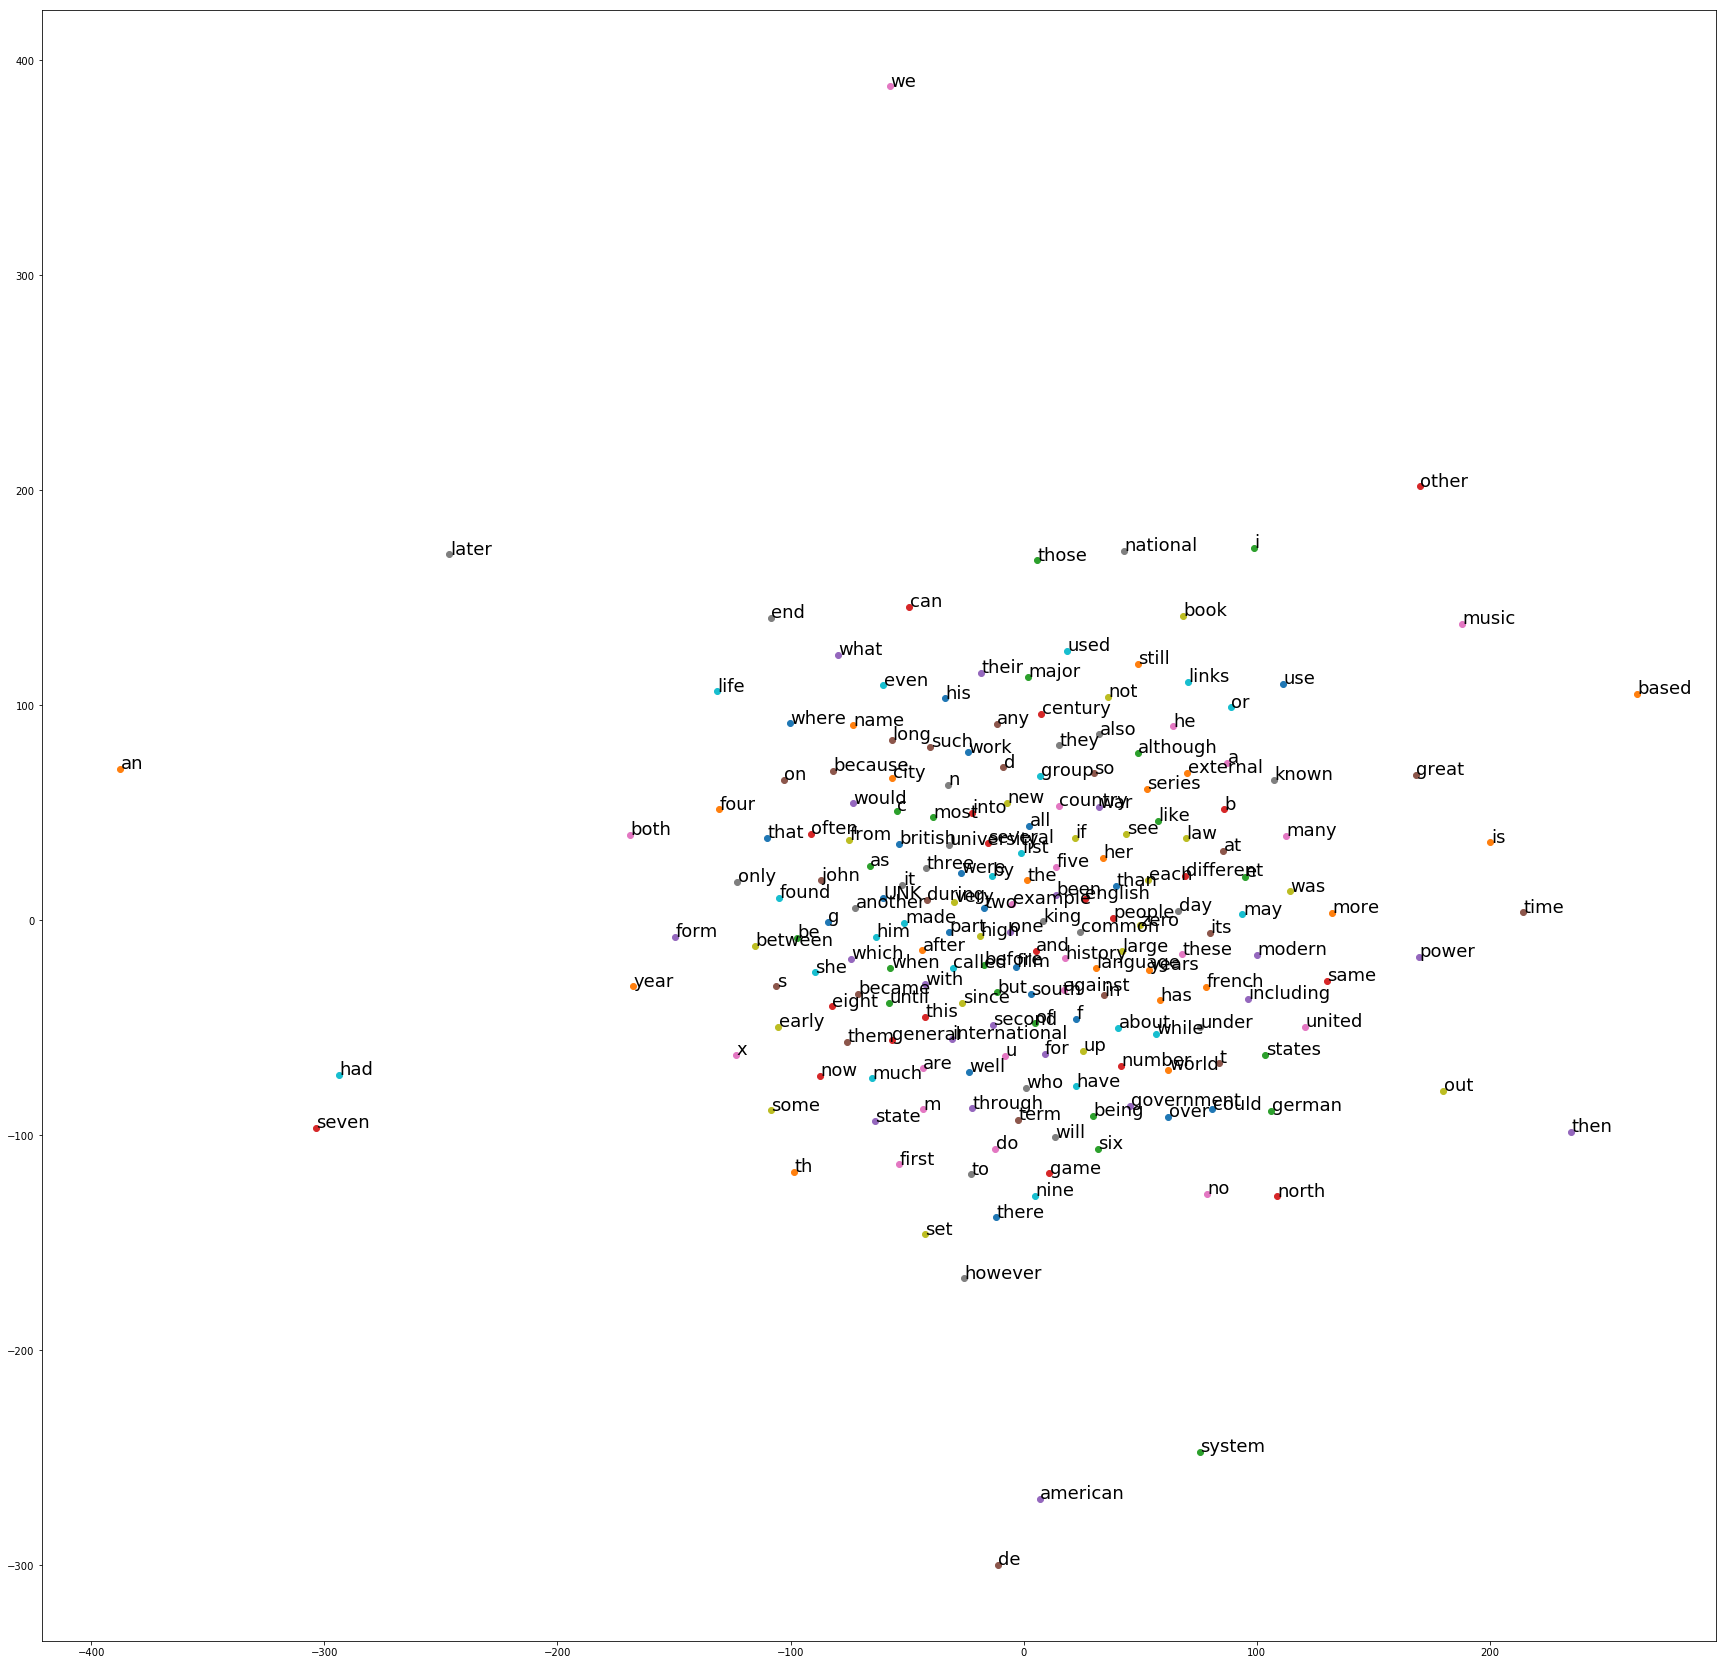

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

rng = 200
embed_matrix = sess.run(model.embed_matrix) # get the embed matrix
X_embedded = TSNE(n_components=2).fit_transform(embed_matrix[:rng])

plt.figure(figsize=(30,30))

for i in range(rng):
  plt.scatter(X_embedded[i][0], X_embedded[i][1])
  plt.text(X_embedded[i][0]+0.2,
           X_embedded[i][1]+0.2,
           index_dictionary.get(i, 0), fontsize=18)

plt.show()